In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import torchinfo
import seaborn as sns
import torchmetrics
import statsmodels
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv("../dataset/train.csv", index_col="PassengerId")
test_df  = pd.read_csv("../dataset/test.csv",  index_col="PassengerId")

# Split inputs/targets
y_train = train_df["Survived"] # This is our output
X_train_raw = train_df.drop(columns=["Survived"]) # This is our input
X_test_raw  = test_df.copy() # This is our test dataset

In [3]:
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [4]:
X_train_raw

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S



In the previous chapter we did our data analysis to understand what transformations we had to apply to our data.

Now we will create a pipeline to apply all those transformations. For that purpose, sklearn has some functions


- FunctionTransformer → “Run my custom function inside sklearn”
- SimpleImputer → “Fix missing values”
- StandardScaler → “Normalize numeric features”
- OneHotEncoder → “Convert categories into binary columns”
- ColumnTransformer → “Apply different logic per column type”
- Pipeline → “Apply a sequence of transforms”


In [5]:
drop_cols = ["Name", "Ticket", "Cabin"]
numeric_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_cols = ["Sex", "Embarked"]

def log1p_fare_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Fare"] = np.log1p(df["Fare"])
    return df

log_fare = FunctionTransformer(log1p_fare_df, validate=False)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = Pipeline(steps=[
    ("drop", FunctionTransformer(lambda df: df.drop(columns=drop_cols, errors="ignore"), validate=False)),
    ("log_fare", log_fare),
    ("columns", ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols),
        ],
        remainder="drop"
    )),
])

We almost have our data ready. The only thing left is splitting it into train, test and validation sets and converting it into tensors.

![title](../images/data_split.png)

![title](../images/data_split_training.png)


In our case, to simplify the process we will just use train and validation sets (we will not use a test set).

For this we can use another sklearn function.

In [6]:
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_raw,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train, # Preserve the class proportions when splitting. Without stratify we might get 90% non-survivors and 10% survivors split
)

And now we apply our pipeline

In [7]:
X_train = preprocess.fit_transform(X_train_raw) # We only use fit_transform in our training set. So the 'normalization model' will use mean and std deviation of columns from the training set.
X_val  = preprocess.transform(X_val_raw)
X_test = preprocess.transform(X_test_raw)

Finally, let's convert to tensors and we are done with the data part.

Although our data is ready, machine learning frameworks usually work with tensors.

![title](../images/tensor.png)

In [8]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1) #view converts from (N,) → (N, 1)

X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=256, shuffle=False)

Now is time to create our neural network. So... what is a neural network?

Formal definition: `An artificial neural network is an interconnected group of nodes, inspired by a simplification of neurons in a brain.`

![title](../images/neural_network.png)

![title](../images/weights.png)

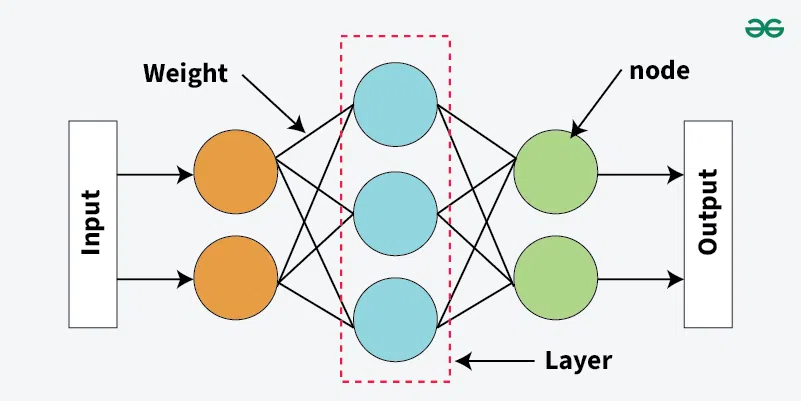

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=16, num_layers=1, dropout=0.1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size))
        self.fc3 = nn.Linear(int(hidden_size), 1)
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        for _ in range(1, self.num_layers):
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)
        x = self.fc3(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleNN(input_size=X_train.shape[1], hidden_size=16, num_layers=2, dropout=0.1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [11]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, correct, total = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        with torch.set_grad_enabled(is_train):
            logits = model(xb)
            loss = loss_fn(logits, yb)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * xb.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, correct / total


best_val_acc = -1.0
best_state = None

for epoch in range(1, 51):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer)
    val_loss, val_acc     = run_epoch(model, val_loader)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

# restore best model
model.load_state_dict(best_state)
print("Best val_acc:", best_val_acc)

Epoch 01 | train_loss=0.6694 train_acc=0.6840 | val_loss=0.6640 val_acc=0.6536
Epoch 02 | train_loss=0.6569 train_acc=0.6868 | val_loss=0.6523 val_acc=0.6592
Epoch 03 | train_loss=0.6449 train_acc=0.7022 | val_loss=0.6379 val_acc=0.6760
Epoch 04 | train_loss=0.6264 train_acc=0.7219 | val_loss=0.6191 val_acc=0.6927
Epoch 05 | train_loss=0.6043 train_acc=0.7360 | val_loss=0.5962 val_acc=0.7207
Epoch 06 | train_loss=0.5808 train_acc=0.7346 | val_loss=0.5721 val_acc=0.7374
Epoch 07 | train_loss=0.5573 train_acc=0.7584 | val_loss=0.5497 val_acc=0.7486
Epoch 08 | train_loss=0.5351 train_acc=0.7500 | val_loss=0.5306 val_acc=0.7765
Epoch 09 | train_loss=0.5135 train_acc=0.7654 | val_loss=0.5151 val_acc=0.7877
Epoch 10 | train_loss=0.5004 train_acc=0.7697 | val_loss=0.5028 val_acc=0.7877
Epoch 11 | train_loss=0.4801 train_acc=0.7851 | val_loss=0.4915 val_acc=0.7821
Epoch 12 | train_loss=0.4735 train_acc=0.7935 | val_loss=0.4824 val_acc=0.7877
Epoch 13 | train_loss=0.4702 train_acc=0.7823 | val_